# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.


The data was organized  by Dr. Sina Kashuk at CUSP.
You can get it from the github repo (use the download link to download it live in your notebook). 
It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


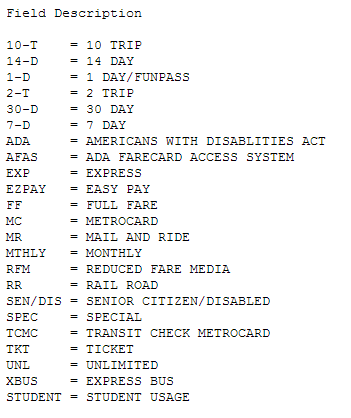

In [1]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

## Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014. 

The data are available to you as a *python data cube*. you can load it as 

```
np.load(“MTA_Fare.npy")
```

and you will end up with a python numpy array of 
shape (600, 23, 194)




## Task 1: 
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

In [10]:
import os
import numpy as np
import datetime
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
path = os.getenv('PUIDATA')
os.system('mv MTA_Fare.npy $PUIDATA')

256

In [12]:
mta = np.load(path+'/MTA_Fare.npy').astype(float)


In [13]:
mta[mta == -1] = np.nan


In [14]:
#must use functions familiar with NaNs (eg nansum)

#sum by station
stations = np.nansum(mta, axis=0)
#sum by swipes
swipes = np.nansum(stations, axis=0)
#sum by user type
user = np.nansum(mta, axis=0)

print np.mean(swipes)
print np.std(swipes)

29781349.8711
2983960.4217


In [15]:
mean_swipes = np.mean(swipes)
std_swipes = np.std(swipes)
event_threshold = 3 * std_swipes
# event is more than 3 stds from the mean in either direction
threshold_value = [mean_swipes + event_threshold, mean_swipes - event_threshold]
print threshold_value

[38733231.136236683, 20829468.606031362]


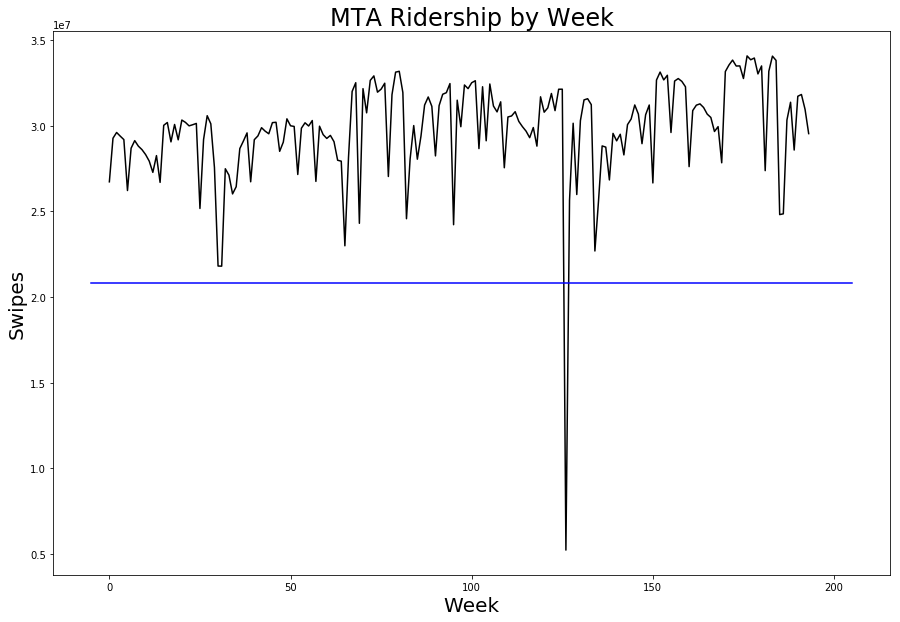

In [16]:
plt.figure(figsize=(15,10))
plt.plot(swipes, 'k-')
plt.plot((-5,205), (threshold_value[1], threshold_value[1]), 'b-')
plt.xlabel('Week', size=20)
plt.ylabel('Swipes', size=20)
plt.title('MTA Ridership by Week', size=24)

#### Figure 1: MTA ridership via swipe count per week from 5/21/2010 - 2/21/2014. There is clearly one week that has a minus three-sigma outlier in ridership. The decline in ridership during this time is likely due to Hurricane Sandy.

In [17]:
for idx, x in enumerate(swipes):
    if x <= threshold_value[1]:
        print idx, x

126 5218686.0


We can see that the 126th week is the week of the event, which corresponds to the week of October 19, 2012. This time period corresponds to the days surrounding Hurricane Sandy's landfall in the area, which would prevent many people from using MTA.

## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [18]:
user.shape

(23, 194)

In [19]:
#an array of above shape is easily dealt with as a pandas dataframe

user_df = pd.DataFrame(user).T

In [20]:
user_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,11494615.0,530524.0,47801.0,186551.0,46808.0,3697443.0,8551937.0,10063.0,333197.0,512032.0,...,123134.0,790110.0,59809.0,28221.0,0.0,124693.0,21060.0,6128.0,358.0,0.0
1,12526859.0,583533.0,51486.0,199229.0,64353.0,3981808.0,9486394.0,11847.0,282755.0,578023.0,...,151948.0,908068.0,69209.0,32333.0,0.0,121713.0,21670.0,6120.0,474.0,0.0
2,12766627.0,586194.0,51636.0,199668.0,56994.0,4033030.0,9476538.0,12277.0,302028.0,615537.0,...,151538.0,914124.0,69574.0,32618.0,0.0,122181.0,21433.0,6490.0,465.0,0.0


In [21]:
card_type = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()


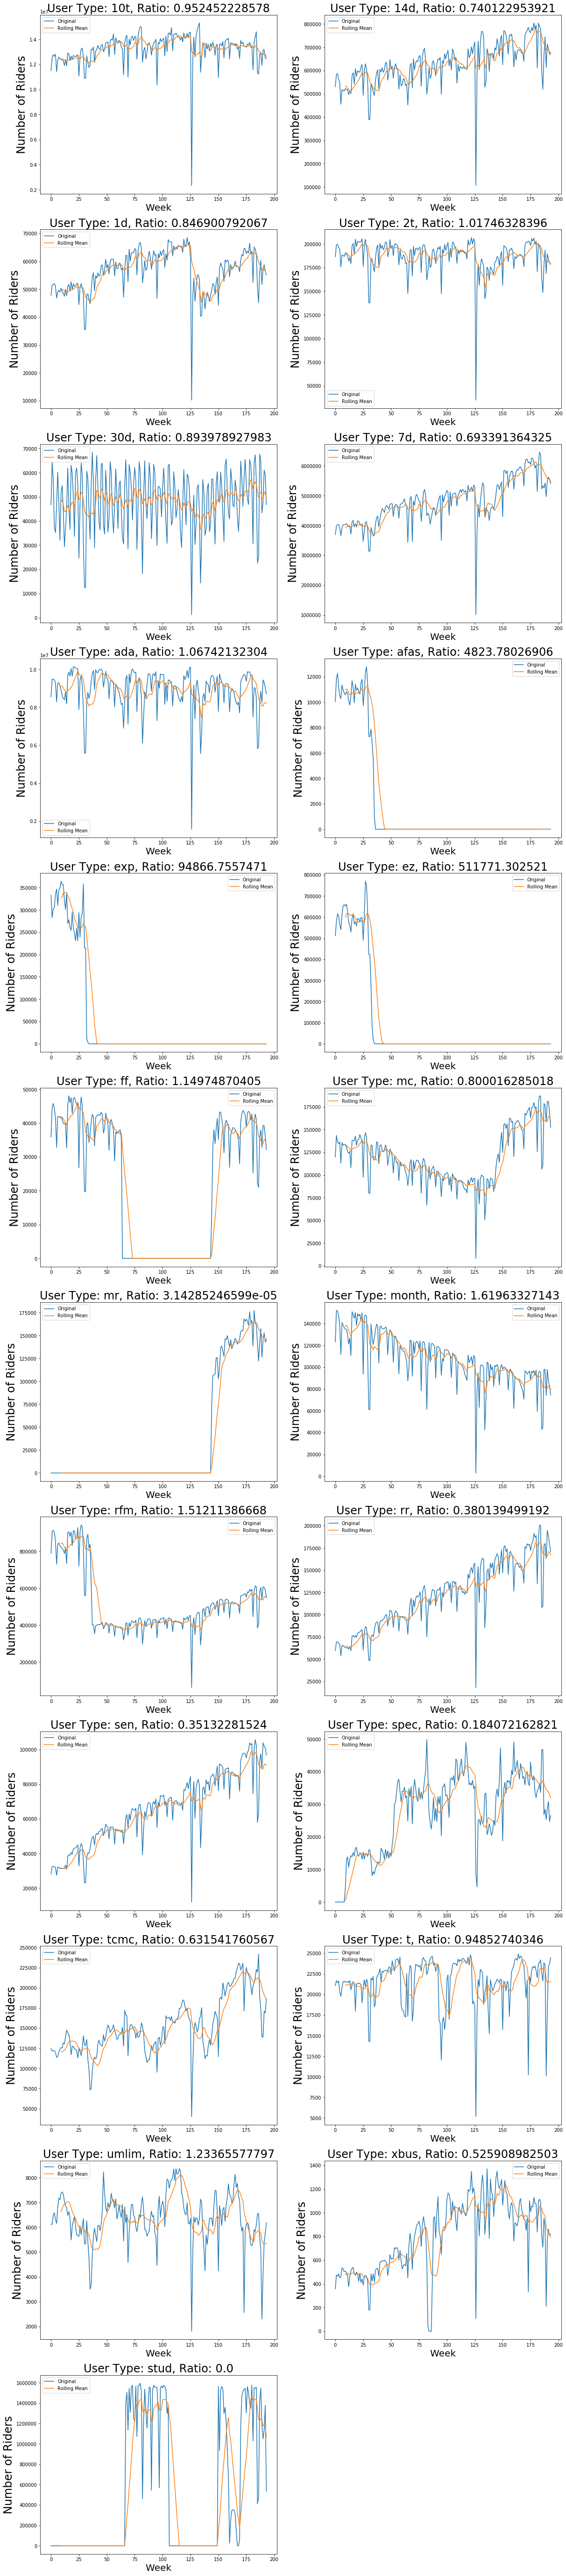

In [22]:
#plot time series for each usertype overlaid with rolling mean

rider_ratio = []
figure = plt.figure(figsize=(20,100))
for i in range(len(user_df.columns)):
    ax = figure.add_subplot(12,2,i+1)
    user_rmean = pd.rolling_mean(user_df[i], 10)
    ax.plot(np.arange(len(user_df[i])), user_df[i], label='Original')
    ax.plot(np.arange(len(user_df[i])), user_rmean, label='Rolling Mean')
    rider_ratio.append(pd.rolling_mean(user_df[i], 10).dropna().head(10).sum() / pd.rolling_mean(user_df[i], 10).dropna().tail(10).sum())
    
    ax.set_title('User Type: {}, Ratio: {}'.format(card_type[i], rider_ratio[i]), fontsize=24)
    plt.xlabel('Week', size=20)
    plt.ylabel('Number of Riders', size=24)
    plt.legend()
plt.show()

### Figure 2: Plots of aggregated ridership by user type over a rolling mean of the user type. Ridership ratio is displayed in the title of each plot to determine which types of riders exhibit positive, negative, or stationary ridership trends across the time period of interest.

In [23]:
# compare user type and ratio in a table (dataframe)
ratios = pd.DataFrame(list(zip(card_type, rider_ratio)), columns=['User Type', 'Ratio'])

In [24]:
ratios

,User Type,Ratio
0,10t,0.952452
1,14d,0.740123
2,1d,0.846901
3,2t,1.017463
4,30d,0.893979
5,7d,0.693391
6,ada,1.067421
7,afas,4823.780269
8,exp,94866.755747
9,ez,511771.302521


### Increasing user types:
Steadily increasing user types include 'rr' and 'sen', as can be seen in the plots above.

### Decreasing user types: 
While afas, exp, and ez user types decrease to a sharp point where they stop appearing altogether, the usertype 'month' has a steadily decreasing ridership.

In [25]:
for i in range (len(user_df.columns)):
    fuller = adfuller(user_df.iloc[:, i])
    if fuller[0] < fuller[4]['5%']:
        print('{} : stationary'.format(card_type[i]))
    else:
        print('{} : NOT stationary'.format(card_type[i]))
    

10t : stationary
14d : NOT stationary
1d : NOT stationary
2t : stationary
30d : stationary
7d : NOT stationary
ada : stationary
afas : NOT stationary
exp : stationary
ez : NOT stationary
ff : NOT stationary
mc : NOT stationary
mr : NOT stationary
month : NOT stationary
rfm : NOT stationary
rr : NOT stationary
sen : NOT stationary
spec : NOT stationary
tcmc : stationary
t : stationary
umlim : stationary
xbus : NOT stationary
stud : NOT stationary


## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [26]:
#sum data by station
station = np.nansum(mta, axis=1)
print station.shape
#convert to pandas dataframe
station_df = pd.DataFrame(station).T
station_df.head(3)

(600, 194)


,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,126878.0,37306.0,6606.0,16378.0,18564.0,19987.0,12449.0,11091.0,10482.0,147187.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,149477.0,46464.0,6881.0,17408.0,19903.0,20625.0,13644.0,11659.0,11030.0,154826.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,152383.0,49359.0,7229.0,17595.0,19948.0,21225.0,13719.0,12037.0,10881.0,155958.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
station_df.shape

(194, 600)

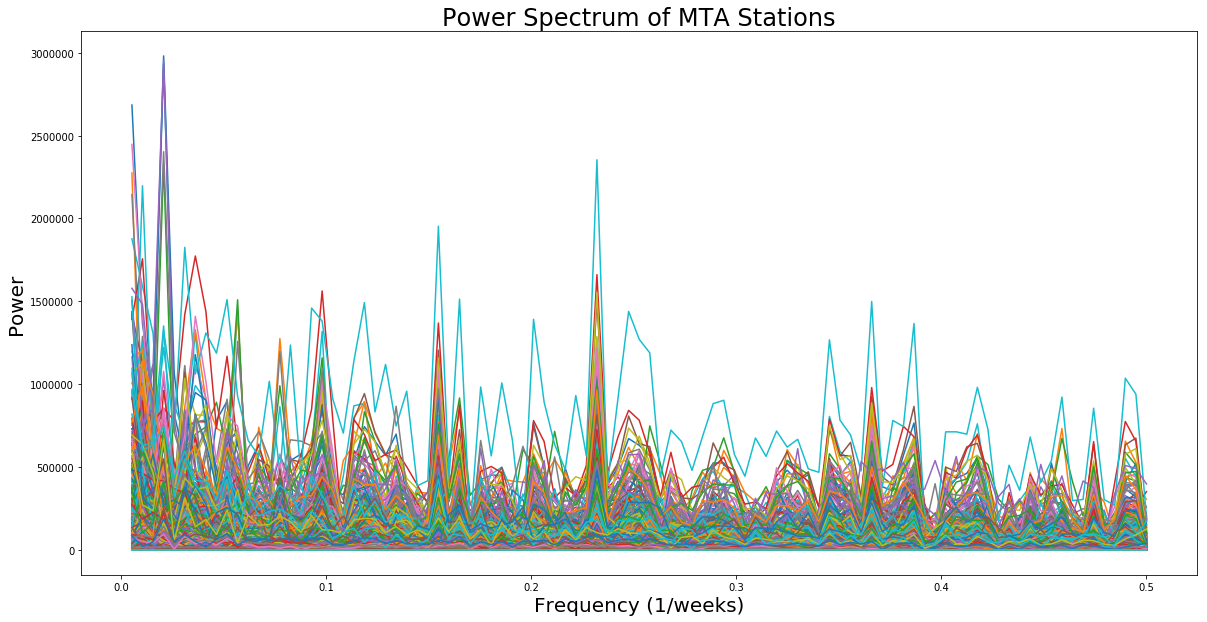

In [28]:
power_values = []
freqs = np.fft.rfftfreq(len(station_df[1]), 1.0)[1:]
figure = plt.figure(figsize=(20,10))

def plot_indices(indices):
    for i in indices: 
        fourier_t = np.abs(np.fft.rfft(station[i]))
        power_values.append(fourier_t)
        plt.plot(freqs, (fourier_t[1:]), '-')
    
    plt.xlabel('Frequency (1/weeks)', size=20)
    plt.ylabel('Power', size=20)
    plt.title('Power Spectrum of MTA Stations', size=24)

plot_indices(range(station_df.shape[1]))

#### Figure 3: The power spectrum of MTA stations, representing the output of a Fourier transform on each station to determine peaks of periodicity across MTA stations.

In [29]:
1/freqs

array([ 194.        ,   97.        ,   64.66666667,   48.5       ,
         38.8       ,   32.33333333,   27.71428571,   24.25      ,
         21.55555556,   19.4       ,   17.63636364,   16.16666667,
         14.92307692,   13.85714286,   12.93333333,   12.125     ,
         11.41176471,   10.77777778,   10.21052632,    9.7       ,
          9.23809524,    8.81818182,    8.43478261,    8.08333333,
          7.76      ,    7.46153846,    7.18518519,    6.92857143,
          6.68965517,    6.46666667,    6.25806452,    6.0625    ,
          5.87878788,    5.70588235,    5.54285714,    5.38888889,
          5.24324324,    5.10526316,    4.97435897,    4.85      ,
          4.73170732,    4.61904762,    4.51162791,    4.40909091,
          4.31111111,    4.2173913 ,    4.12765957,    4.04166667,
          3.95918367,    3.88      ,    3.80392157,    3.73076923,
          3.66037736,    3.59259259,    3.52727273,    3.46428571,
          3.40350877,    3.34482759,    3.28813559,    3.23333

In [31]:
#identify top 4 stations with most prominent periodic trend
#for station_idx, power_spectrum in enumerate(power_values):
#    for spectrum_idx, val in enumerate(power_spectrum):
#        if val >= 2300000:
#            print station_idx, spectrum_idx, val
            
powers = [power_spectrum[4] for power_spectrum in power_values]
threshold = sorted(powers)[-4]

for idx, peak in enumerate(powers):
    if peak >= threshold:
        print idx, peak

0 2980160.6356
150 2931895.87695
194 2950388.92921
327 2402218.58096


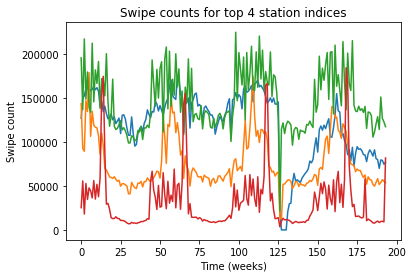

In [32]:
indices = [0, 150, 194, 327]
for i in indices:
    plt.plot(station[i])
    
plt.title('Swipe counts for top 4 station indices')
plt.xlabel('Time (weeks)')
plt.ylabel('Swipe count')

#### Figure 4: The swipe counts of the top 4 MTA stations. We note that station 194 is the same station provided by the professor in the hints below.

## The periodic peak in rides occurs in the summer months and wanes in the winter months. Peaks here are dependent on seasonality, such as in ferry services to islands or seasonal station availability.

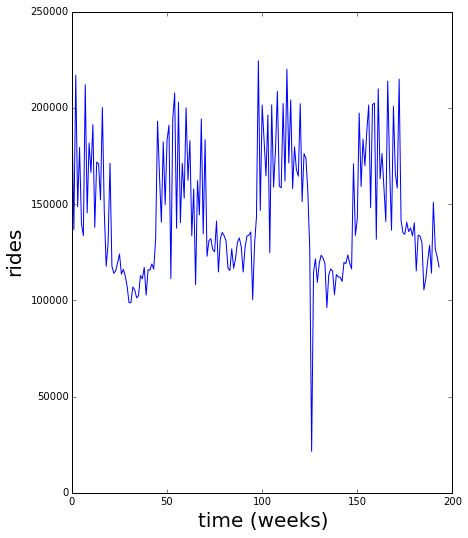

In [63]:
#and here is one of he periodic time series you should find by identifying the time series with the most power 
#at 1/52 weeks frequency in fourier space

### The blue plot above came pre-rendered in the skeleton notebook. It shows station 194, as it was discovered from plotting Figure 4.

## ASH - Score 100. Extra Credit 0